In [1]:
import codecs
import glob
import multiprocessing
import os
import re

import nltk
from nltk.corpus import stopwords
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# ability to split sentences (sentence boundary detection)...
nltk.download("punkt")
# common words to ignore
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# get book filenames
book_filenames = sorted(glob.glob('03_hp/*.txt'))

print("Found books:")
book_filenames

Found books:


["03_hp/Harry Potter 1 - Sorcerer's Stone.txt",
 '03_hp/Harry Potter 2 - Chamber of Secrets.txt',
 '03_hp/Harry Potter 3 - The Prisoner Of Azkaban.txt',
 '03_hp/Harry Potter 4 - The Goblet Of Fire.txt',
 '03_hp/Harry Potter 5 - Order of the Phoenix.txt',
 '03_hp/Harry Potter 6 - The Half Blood Prince.txt',
 '03_hp/Harry Potter 7 - Deathly Hollows.txt']

In [4]:
# corpus => collection of written texts (entire work of author or subject)
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '03_hp/Harry Potter 1 - Sorcerer's Stone.txt'...
Corpus is now 448810 characters long

Reading '03_hp/Harry Potter 2 - Chamber of Secrets.txt'...
Corpus is now 947729 characters long

Reading '03_hp/Harry Potter 3 - The Prisoner Of Azkaban.txt'...
Corpus is now 1569784 characters long

Reading '03_hp/Harry Potter 4 - The Goblet Of Fire.txt'...
Corpus is now 2690176 characters long

Reading '03_hp/Harry Potter 5 - Order of the Phoenix.txt'...
Corpus is now 4190900 characters long

Reading '03_hp/Harry Potter 6 - The Half Blood Prince.txt'...
Corpus is now 5181714 characters long

Reading '03_hp/Harry Potter 7 - Deathly Hollows.txt'...
Corpus is now 6320858 characters long



In [5]:
# pickle - python specific way to serializes the data structure (binary)
# http://www.diveintopython3.net/serializing.html
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') 
raw_sentences = tokenizer.tokenize(corpus_raw)

In [6]:
#convert into a list of words and clean...
stops = set(stopwords.words("english"))

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()

    valid_words = [word.lower() for word in words if word.lower() not in stops]
    
    return valid_words

In [7]:
# sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [8]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.
['dursleys', 'small', 'son', 'called', 'dudley', 'opinion', 'finer', 'boy', 'anywhere']


In [9]:
# how many words
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 573,062 tokens


In [10]:
# build model - 
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
# more dimensions, more computationally expensive to train but also more accurate
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

# gensim word2vec... gensim => generate similar
# discover semantic structure of documents
hp2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [11]:
# collect word and frequencies in internal tree struct
hp2vec.build_vocab(sentences)
print (hp2vec)

Word2Vec(vocab=11679, size=300, alpha=0.025)


In [12]:
# https://rare-technologies.com/word2vec-tutorial/#training
hp2vec.train(sentences, total_examples=hp2vec.corpus_count, epochs=hp2vec.epochs) # add total_examples, epocs

(2580844, 2865310)

In [13]:
if not os.path.exists("trained"):
    os.makedirs("trained")

hp2vec.save(os.path.join("trained", "hp2vec.w2v"))

In [14]:
hp2vec = w2v.Word2Vec.load(os.path.join("trained", "hp2vec.w2v"))

In [15]:
#my video - how to visualize a dataset easily
# tsne => t-distributed Stochastic Neibor Embedding
# used for visualize high-dimensional data
# n_components => dimension of embeded space
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [16]:
all_word_vectors_matrix = hp2vec.wv.vectors # different

In [17]:
# Fit matrix into an embedded space and return that transformed output.
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [18]:
# https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe
# 2-d labled data struct (like sql table)
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[hp2vec.wv.vocab[word].index])
            for word in hp2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [19]:
# first N rows
points.head(10)

,word,x,y
0,harry,-9.426554,-42.824879
1,potter,-70.053986,-21.630194
2,sorcerer,-69.425575,-4.684664
3,stone,24.797104,-63.719147
4,chapter,-25.379114,-24.206858
5,one,71.429276,39.988808
6,boy,-39.722980,-38.620270
7,lived,-70.199615,-7.502961
8,mr,-30.140104,-36.839027
9,mrs,-30.067408,-36.765858


In [20]:
# seaborn: statistical data visualization (https://seaborn.pydata.org/index.html)
# https://seaborn.pydata.org/generated/seaborn.set_context.html?highlight=set_context
# set_context: (paper, notebook, talk, poster)
sns.set_context('poster')

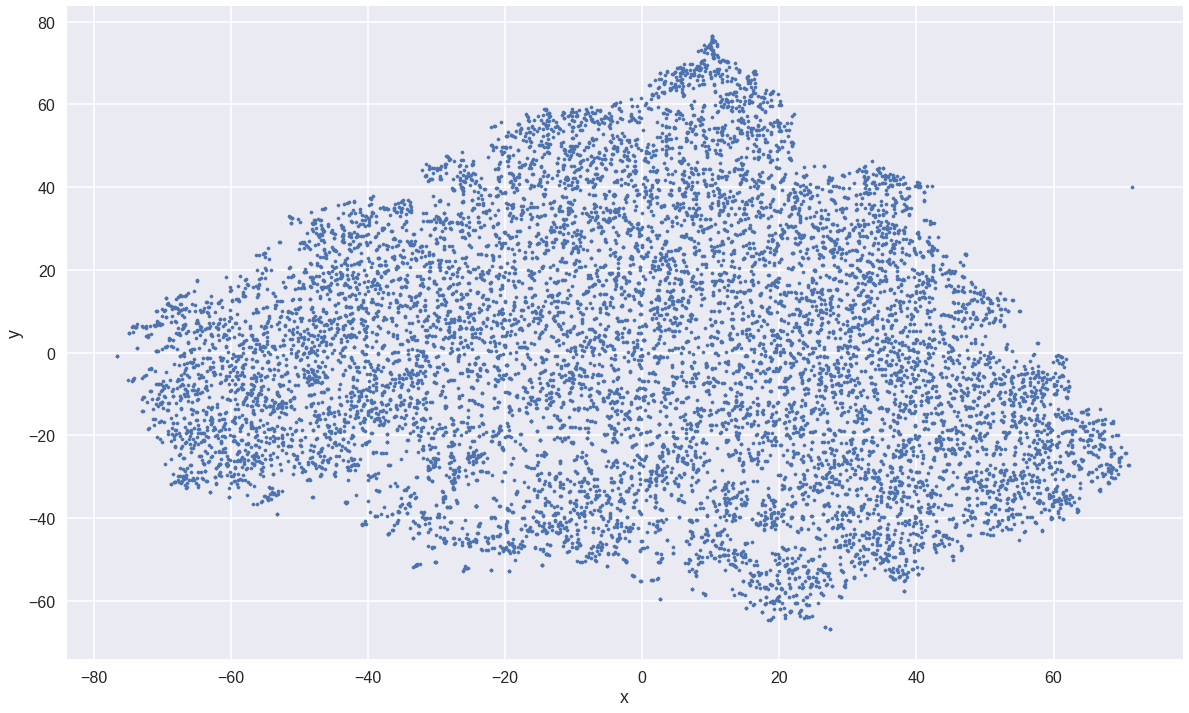

In [21]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [22]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

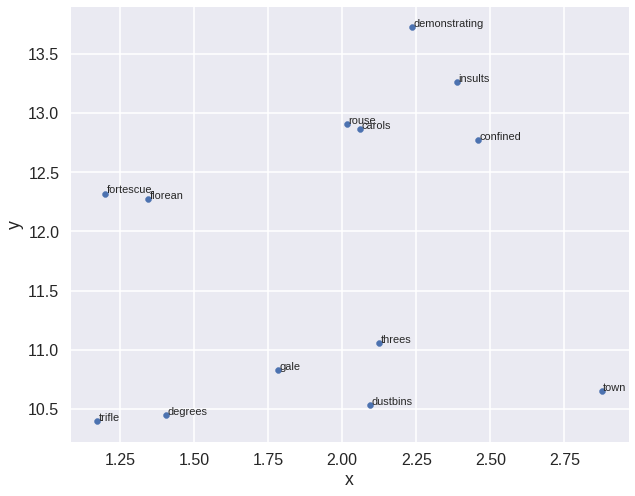

In [23]:
# plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))
plot_region(x_bounds=(0, 3), y_bounds=(10, 15))

In [24]:
hp2vec.wv.most_similar("muggle")

[('borns', 0.8853442668914795),
 ('born', 0.8534098863601685),
 ('children', 0.8519080877304077),
 ('wizarding', 0.850256621837616),
 ('bagshot', 0.8489675521850586),
 ('misuse', 0.835685133934021),
 ('artifacts', 0.8345080614089966),
 ('rr', 0.8300884366035461),
 ('members', 0.8292784690856934),
 ('international', 0.8284382820129395)]

In [25]:
hp2vec.wv.most_similar("bellatrix")

[('narcissa', 0.9195432662963867),
 ('greyback', 0.8760130405426025),
 ('lestrange', 0.8419686555862427),
 ('lucius', 0.8299016952514648),
 ('pettigrew', 0.8269718885421753),
 ('draco', 0.8068459033966064),
 ('softly', 0.8057682514190674),
 ('wormtail', 0.7982628345489502),
 ('travers', 0.7704431414604187),
 ('ogden', 0.7688493132591248)]

In [26]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hp2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [27]:

nearest_similarity_cosmul("harry", "ron", "draco")
# nearest_similarity_cosmul("Jaime", "sword", "wine")
# nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

harry is related to ron, as lucius is related to draco


'lucius'